=== TRAINING MODEL ARGUS (DATASET V2 - 13 MFCC) ===
[1/6] Dataset dimuat: 760 baris.
      Kolom ditemukan: ['timestamp', 'rms', 'zcr', 'spectral_centroid', 'label', 'mfcc_1', 'mfcc_2', 'mfcc_3', 'mfcc_4', 'mfcc_5', 'mfcc_6', 'mfcc_7', 'mfcc_8', 'mfcc_9', 'mfcc_10', 'mfcc_11', 'mfcc_12', 'mfcc_13']

[2/6] Preprocessing Data...
      Fitur yang digunakan (16):
      ['rms', 'zcr', 'spectral_centroid', 'mfcc_1', 'mfcc_2', 'mfcc_3', 'mfcc_4', 'mfcc_5', 'mfcc_6', 'mfcc_7', 'mfcc_8', 'mfcc_9', 'mfcc_10', 'mfcc_11', 'mfcc_12', 'mfcc_13']
      Data Training: 608 sampel
      Data Testing:  152 sampel

[3/6] Melatih Random Forest (Optimized)...
      Training selesai.

[4/6] Evaluasi Model...

---> AKURASI: 92.76% <---

Laporan Klasifikasi:
                     precision    recall  f1-score   support

normal_conversation       0.93      0.93      0.93        46
            silence       0.92      0.94      0.93        52
         whispering       0.92      0.91      0.92        54

          

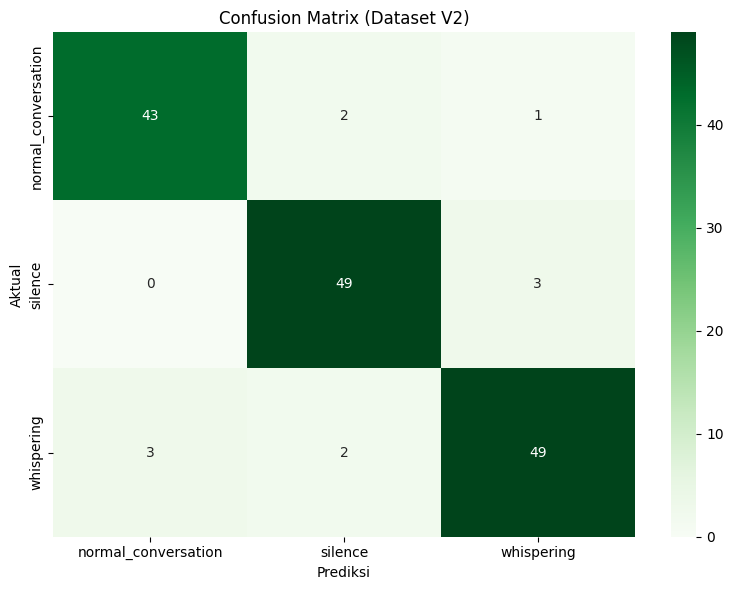

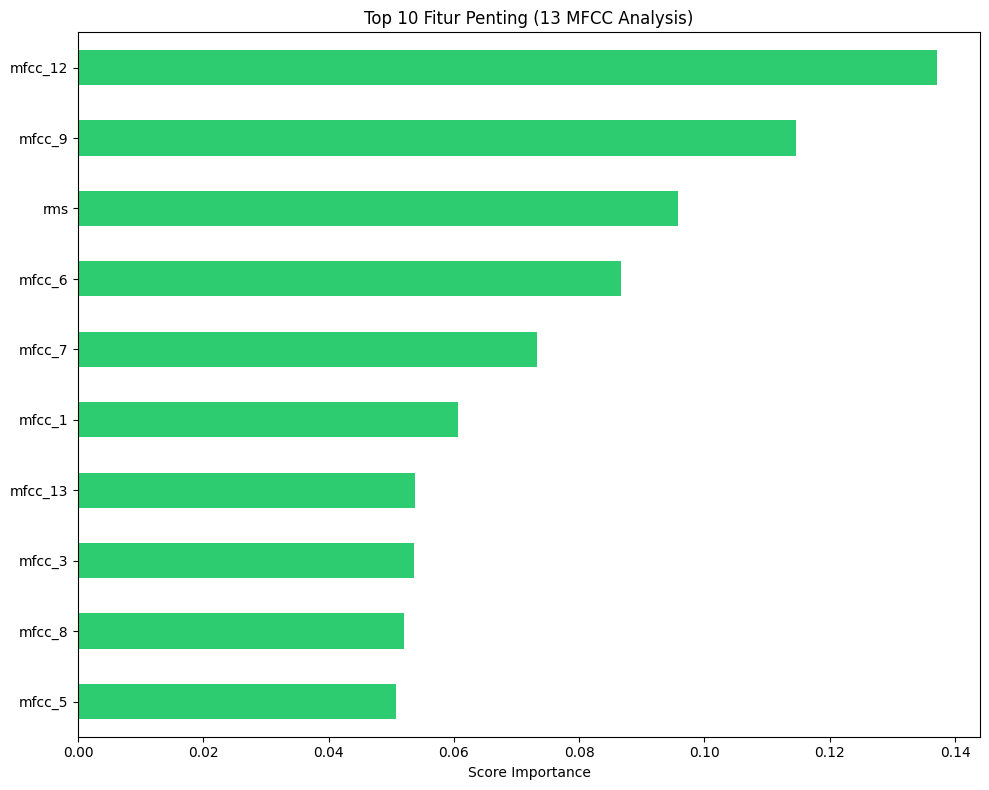


[6/6] Menyimpan Model & Scaler...
      Model disimpan: argus_speech_model_v2.pkl
      Scaler disimpan: argus_scaler_v2.pkl

--- Simulasi Prediksi Data Baru ---
Label Asli: normal_conversation
Prediksi AI: whispering
Confidence: 71.00%
=== SELESAI ===


c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [ ]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# ================= KONFIGURASI =================
# Pastikan nama file csv sesuai dengan file dataset baru Anda
DATASET_FILE = "audio_dataset.csv"  
MODEL_FILENAME = "argus_speech_model_v2.pkl"
SCALER_FILENAME = "argus_scaler_v2.pkl"
TEST_SIZE = 0.2
RANDOM_STATE = 42
# ===============================================

def train_new_model():
    print("=== TRAINING MODEL ARGUS (DATASET V2 - 13 MFCC) ===")
    
    # 1. LOAD DATASET
    # -------------------------------------------
    try:
        df = pd.read_csv(DATASET_FILE)
        print(f"[1/6] Dataset dimuat: {len(df)} baris.")
        print("      Kolom ditemukan:", list(df.columns))
    except FileNotFoundError:
        print(f"Error: File '{DATASET_FILE}' tidak ditemukan.")
        return

    # Cek apakah dataset kosong
    if df.empty:
        print("Error: Dataset kosong.")
        return

    # 2. PREPROCESSING
    # -------------------------------------------
    print("\n[2/6] Preprocessing Data...")
    
    # A. Memisahkan Fitur (X) dan Target (y)
    # Kita harus membuang kolom yang BUKAN fitur angka
    # 'timestamp' dibuang karena string/waktu
    # 'label' dibuang karena itu target prediksi
    
    # Daftar kolom yang akan dibuang
    cols_to_drop = ['timestamp', 'label']
    
    # Menangani error jika kolom tidak ada (misal nama kolom beda dikit)
    try:
        X = df.drop(cols_to_drop, axis=1)
        y = df['label']
    except KeyError as e:
        print(f"Error: Kolom tidak ditemukan di CSV: {e}")
        print("Pastikan nama kolom di CSV adalah: timestamp, label")
        return

    print(f"      Fitur yang digunakan ({len(X.columns)}):")
    print(f"      {list(X.columns)}")

    # B. Split Data (80% Train, 20% Test)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y
    )
    
    # C. Scaling (Standarisasi)
    # Sangat penting karena 'spectral_centroid' (~1158) jauh lebih besar dari 'rms' (~0.001)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    print(f"      Data Training: {len(X_train)} sampel")
    print(f"      Data Testing:  {len(X_test)} sampel")

    # 3. TRAINING MODEL
    # -------------------------------------------
    print("\n[3/6] Melatih Random Forest (Optimized)...")
    
    # n_estimators=200 agar lebih akurat menangani 13 fitur MFCC
    model = RandomForestClassifier(n_estimators=200, random_state=RANDOM_STATE)
    model.fit(X_train_scaled, y_train)
    
    print("      Training selesai.")

    # 4. EVALUASI
    # -------------------------------------------
    print("\n[4/6] Evaluasi Model...")
    
    y_pred = model.predict(X_test_scaled)
    
    acc = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    
    print(f"\n---> AKURASI: {acc*100:.2f}% <---")
    print("\nLaporan Klasifikasi:")
    print(report)

    # 5. VISUALISASI
    # -------------------------------------------
    print("[5/6] Membuat Visualisasi...")
    
    # A. Confusion Matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Greens',
                xticklabels=model.classes_, yticklabels=model.classes_)
    plt.title('Confusion Matrix (Dataset V2)')
    plt.ylabel('Aktual')
    plt.xlabel('Prediksi')
    plt.tight_layout()
    plt.savefig('v2_confusion_matrix.png')
    plt.show()
    
    # B. Feature Importance
    # Melihat fitur mana (MFCC ke berapa?) yang paling berpengaruh
    feature_importances = pd.Series(model.feature_importances_, index=X.columns)
    
    plt.figure(figsize=(10, 8))
    # Tampilkan 10 fitur terpenting saja agar grafik rapi
    feature_importances.nlargest(10).plot(kind='barh', color='#2ecc71')
    plt.title('Top 10 Fitur Penting (13 MFCC Analysis)')
    plt.xlabel('Score Importance')
    plt.gca().invert_yaxis() # Agar fitur paling penting ada di atas
    plt.tight_layout()
    plt.savefig('v2_feature_importance.png')
    plt.show()

    # 6. SIMPAN MODEL
    # -------------------------------------------
    print("\n[6/6] Menyimpan Model & Scaler...")
    
    with open(MODEL_FILENAME, 'wb') as f:
        pickle.dump(model, f)
        
    with open(SCALER_FILENAME, 'wb') as f:
        pickle.dump(scaler, f)
        
    print(f"      Model disimpan: {MODEL_FILENAME}")
    print(f"      Scaler disimpan: {SCALER_FILENAME}")
    
    # SIMULASI PREDIKSI
    print("\n--- Simulasi Prediksi Data Baru ---")
    # Ambil 1 baris data tes acak
    sample_idx = 0
    raw_data = X_test.iloc[sample_idx].values
    true_label = y_test.iloc[sample_idx]
    
    # Scale data (Wajib sama dengan saat training)
    input_data = scaler.transform([raw_data])
    
    prediction = model.predict(input_data)[0]
    probs = model.predict_proba(input_data)[0]
    confidence = np.max(probs) * 100
    
    print(f"Label Asli: {true_label}")
    print(f"Prediksi AI: {prediction}")
    print(f"Confidence: {confidence:.2f}%")
    print("=== SELESAI ===")

if __name__ == "__main__":
    train_new_model()